# Chinook Music Store

This is an analysis of a fake music store and answering from busines questions.

See chinook-schema.png for the database schema.

## Basic setup

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
db = 'chinook.db'

def run_query(q,idx=None):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn, index_col=idx)

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)
    
def show_tables():
    q = 'SELECT \
    name, \
    type \
FROM sqlite_master \
WHERE type IN ("table","view");'
    return run_query(q)

print(show_tables())

              name   type
0            album  table
1           artist  table
2         customer  table
3         employee  table
4            genre  table
5          invoice  table
6     invoice_line  table
7       media_type  table
8         playlist  table
9   playlist_track  table
10           track  table
11  cust_countries   view


In [2]:
q = '''WITH genres AS
    (
    SELECT
        g.genre_id,
        t.track_id,
        g.name
    FROM genre g
    INNER JOIN track t ON t.genre_id = g.genre_id
    ),
    usa_track_total AS
    (
    SELECT
        SUM(il.quantity) all_track_total
    FROM invoice_line il
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    WHERE i.billing_country = "USA"
    ),
    usa_track_cost_total AS
    (
    SELECT
        il.track_id,
        SUM(il.unit_price * il.quantity) track_total
    FROM invoice_line il
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN invoicei  ON i.invoice_id = il.invoice_id
    WHERE i.billing_country = "USA"
    GROUP BY track_id
    ),
    usa_track_num_total AS
    (
    SELECT
        il.track_id,
        SUM(il.quantity) track_total
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    WHERE i.billing_country = "USA"
    GROUP BY il.track_id
    ),
    genre_total AS
    (
    SELECT
        g.genre_id,
        SUM(utn.track_total) genre_total
    FROM usa_track_num_total utn
    INNER JOIN genres g ON g.track_id = utn.track_id
    GROUP BY g.genre_id
    )

SELECT
    g.name genre,
    gt.genre_total genre_num,
    ROUND(CAST(gt.genre_total AS FLOAT) / (SELECT all_track_total FROM usa_track_total), 3) genre_per
FROM genre g
INNER JOIN genre_total gt ON g.genre_id = gt.genre_id
GROUP BY g.genre_id
ORDER BY genre_num DESC
'''
genre_sales_usa = run_query(q, "genre")
print(genre_sales_usa)

                    genre_num  genre_per
genre                                   
Rock                      561      0.534
Alternative & Punk        130      0.124
Metal                     124      0.118
R&B/Soul                   53      0.050
Blues                      36      0.034
Alternative                35      0.033
Latin                      22      0.021
Pop                        22      0.021
Hip Hop/Rap                20      0.019
Jazz                       14      0.013
Easy Listening             13      0.012
Reggae                      6      0.006
Electronica/Dance           5      0.005
Classical                   4      0.004
Heavy Metal                 3      0.003
Soundtrack                  2      0.002
TV Shows                    1      0.001


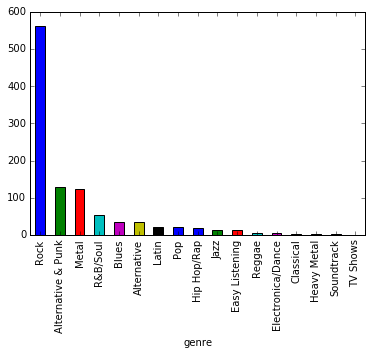

In [3]:
genre_sales_usa.loc[:,"genre_num"].plot.bar()

From these results you can see the number of tracks sold per genre, with Rock being the highest and going down the list. If a list of artists were to be added to the store, the genres with the highest sales should be prioritized. In a hypothetical list including Hip-Hop, Punk, Pop, and Blues, the highest three artists to added would be those from genres Punk then Blues then Pop.

In [4]:
q = '''WITH customer_sum AS
    (
    SELECT 
        e.employee_id,
        e.reports_to,
        e.birthdate,
        e.hire_date,
        c.customer_id,
        SUM(i.total) total_sales 
    FROM customer c
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    INNER JOIN employee e ON e.employee_id = c.support_rep_id
    GROUP BY e.employee_id
    )

SELECT 
    e.first_name || " " || e.last_name employee_name,
    e.birthdate,
    e.hire_date,
    c.total_sales
FROM employee e
INNER JOIN customer_sum c ON c.employee_id = e.employee_id
ORDER BY total_sales DESC
'''
employee_sales = run_query(q, "employee_name")
print(employee_sales)

                         birthdate            hire_date  total_sales
employee_name                                                       
Jane Peacock   1973-08-29 00:00:00  2017-04-01 00:00:00      1731.51
Margaret Park  1947-09-19 00:00:00  2017-05-03 00:00:00      1584.00
Steve Johnson  1965-03-03 00:00:00  2017-10-17 00:00:00      1393.92


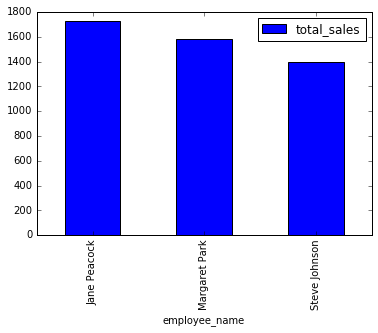

In [5]:
employee_sales.loc[:,["total_sales"]].plot.bar()

From the last two pieces of information, we can see the ranking of employees based on the number of sales they made. This is in terms of the total purchases made by customers who had these employees assigned to them (at the first time the customer made a purchase).

Checking the trend, this may be due to the fact that Jane Peacock has the most experience (earliest hire date). Being younger may also be a factor, though Steve Johnson has the lowest sales and is the second youngest. There's not enough data to determine if age is a factor.

## Sales data per country

In [6]:
c = '''
CREATE VIEW cust_countries AS
     SELECT
         c.country,
         count(c.customer_id) customer_count,
         sum(i.total) customer_total,
         count(i.invoice_id) invoice_count
     FROM customer c
     INNER JOIN invoice i ON c.customer_id = i.customer_id
     GROUP by 1
     ORDER by 2 DESC;
'''
run_command(c)

OperationalError: table cust_countries already exists

In [7]:
#Uncomment if need to drop view
#c = '''
#DROP VIEW cust_countries;
#'''
#run_command(c)

In [8]:
q = '''
SELECT
    country,
    customer_count customers_count,
    customer_total customers_sales_total,
    ROUND(CAST(customer_total AS FLOAT) / customer_count, 2) avg_sales_customer,
    ROUND(CAST(customer_total AS FLOAT) / invoice_count, 2) avg_order_value
FROM
    (
    SELECT
        cc.*,
        CASE
            WHEN cc.customer_count = 1 THEN 1
            ELSE 0
        END AS sort
    FROM cust_countries cc
   )
ORDER BY customer_total DESC
'''
#cust_country = run_query(q, "country")
cust_country = run_query(q)
cust_country

,country,customers_count,customers_sales_total,avg_sales_customer,avg_order_value
0,USA,131,1040.49,7.94,7.94
1,Canada,76,535.59,7.05,7.05
2,Brazil,61,427.68,7.01,7.01
3,France,50,389.07,7.78,7.78
4,Germany,41,334.62,8.16,8.16
5,Czech Republic,30,273.24,9.11,9.11
6,United Kingdom,28,245.52,8.77,8.77
7,Portugal,29,185.13,6.38,6.38
8,India,21,183.15,8.72,8.72
9,Ireland,13,114.84,8.83,8.83


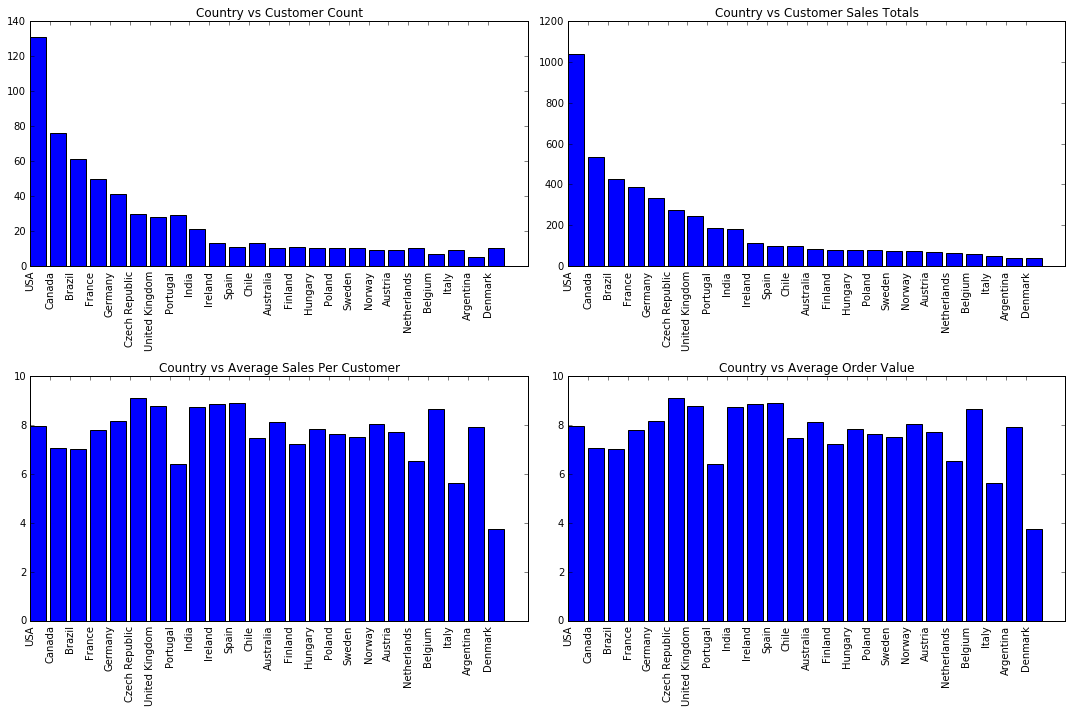

In [23]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

#Plot 1
xrange=range(len(cust_country.loc[:,"country"]))
ax1.bar(left=xrange, height=cust_country.loc[:,"customers_count"], 
        tick_label=cust_country.loc[:,"country"], align="edge")
ax1.set_title("Country vs Customer Count")

#Plot 2
ax2.bar(left=xrange, height=cust_country.loc[:,"customers_sales_total"], 
        tick_label=cust_country.loc[:,"country"], align="edge")
ax2.set_title("Country vs Customer Sales Totals")

#Plot 3
ax3.bar(left=xrange, height=cust_country.loc[:,"avg_sales_customer"], 
        tick_label=cust_country.loc[:,"country"], align="edge")
ax3.set_title("Country vs Average Sales Per Customer")

#Plot 4
ax4.bar(left=xrange, height=cust_country.loc[:,"avg_order_value"], 
        tick_label=cust_country.loc[:,"country"], align="edge")
ax4.set_title("Country vs Average Order Value")

#Rotate tick labels
for ax in fig.axes:
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=90)

#Set better spacing between subplots
fig.tight_layout()

#fig.show()

From the results, the countries to focus on for maximum customers and sales is USA, Canada, Brazil, France, Germany, etc. The average sales across customers and orders are similar, but the highest numbers of customers and total sales are from these countries.

## Percentage of invoices will full album purchases versus individual tracks of an album

In [35]:
q = '''
WITH invoice_album AS
    (
    SELECT 
        i.invoice_id,
        MAX(t.album_id) album_id
    FROM invoice i
    INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
    INNER JOIN track t ON il.track_id = t.track_id
    GROUP BY i.invoice_id
    ),
    full_album AS
    (
    SELECT
        i.invoice_id,
        CASE WHEN (SELECT il.track_id FROM invoice_line il INNER JOIN track t ON il.track_id = t.track_id WHERE il.invoice_id = i.invoice_id
                   EXCEPT
                   SELECT t.track_id FROM track t INNER JOIN album a ON t.album_id = a.album_id WHERE t.album_id = ia.album_id) IS NULL
                   AND
                   (SELECT t.track_id FROM track t INNER JOIN album a ON t.album_id = a.album_id WHERE t.album_id = ia.album_id
                   EXCEPT
                   SELECT il.track_id FROM invoice_line il INNER JOIN track t ON il.track_id = t.track_id WHERE il.invoice_id = i.invoice_id) IS NULL THEN 1
             ELSE 0
        END AS track_album_purchase
    FROM invoice i
    INNER JOIN invoice_album ia on ia.invoice_id = i.invoice_id
    )

SELECT
    COUNT(invoice_id) number_invoices,
    ROUND(SUM(track_album_purchase) / CAST(COUNT(invoice_id) AS FLOAT), 2) percent_invoices_full_album
FROM full_album;
'''
invoices = run_query(q)
invoices

,number_invoices,percent_invoices_full_album
0,614,0.19


Based on the above, only about 19% of all invoices contain all the tracks for an album. All others only purchase individual tracks for a single album. This means that if the Chinook store switched to a business model of selling only individual tracks versus full albums, there would be significant cost savings since only a small percentage of invoices want full albums anyway.